In [1]:
# Basic libraries
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.pylab as pylab

# Preprocessing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Neural Network
from keras.models import Sequential
from keras.layers import Dense

# My modules
from modules.efficiency_matrix import effmatrix

C:\Users\jfcre\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
seed = 11
np.random.seed(seed)

In [3]:
Truth1n = 72
Truth2n = 48

In [4]:
# sample region
min1n = 50 #0
max1n = int(Truth1n+3*np.sqrt(Truth1n)+0.5)
min2n = 20 #0
max2n = int(Truth2n+3*np.sqrt(Truth2n)+0.5)

# plot size
x_max = int(max1n+7*np.sqrt(max1n)+0.5)
y_max = int(max2n+7*np.sqrt(max2n)+0.5)

# plot size for NN
# (takes too much memory to do full size)
NN_x_max = 70
NN_y_max = 70

# how many times we sample the 2D-poisson dist. at a given (1n,2n) truth value
nsamples = 1000

# HALO efficiency matrix
M = effmatrix()

xincr = 1#int(max1n/NN_x_max)
yincr = 1#int(max2n/NN_y_max)

In [5]:
oneNtruth_set = []
twoNtruth_set = []
oneNobs_set   = []
twoNobs_set   = []

count = 0
for i in range(min1n,max1n+1,xincr):
    for j in range(min2n,max2n+1,yincr):
        
        if i == 72 and j ==48:
            print(count)
        count += 1
        
        oneNtruth = []
        twoNtruth = []
        oneNobs   = []
        twoNobs   = []

        for k in range(nsamples):
            
            # truth distribution
            oneN = np.random.poisson(i)
            twoN = np.random.poisson(j)

            # calculate observed distribution
            oneN_obs = 0
            twoN_obs = 0
            for n in range(oneN):
                rand = np.random.random()
                if rand < M.item(0,0):
                    oneN_obs += 1
            for n in range(twoN):
                rand = np.random.random()
                if rand < M.item(0,1):
                    oneN_obs += 1
                elif rand < M.item(0,1) + M.item(1,1):
                    twoN_obs += 1
                    
            oneNtruth.append(oneN)
            twoNtruth.append(twoN)
            oneNobs.append(oneN_obs)
            twoNobs.append(twoN_obs)

        # add arrays to sets
        oneNtruth_set.append(oneNtruth)
        twoNtruth_set.append(twoNtruth)
        oneNobs_set.append(oneNobs)
        twoNobs_set.append(twoNobs)


1128


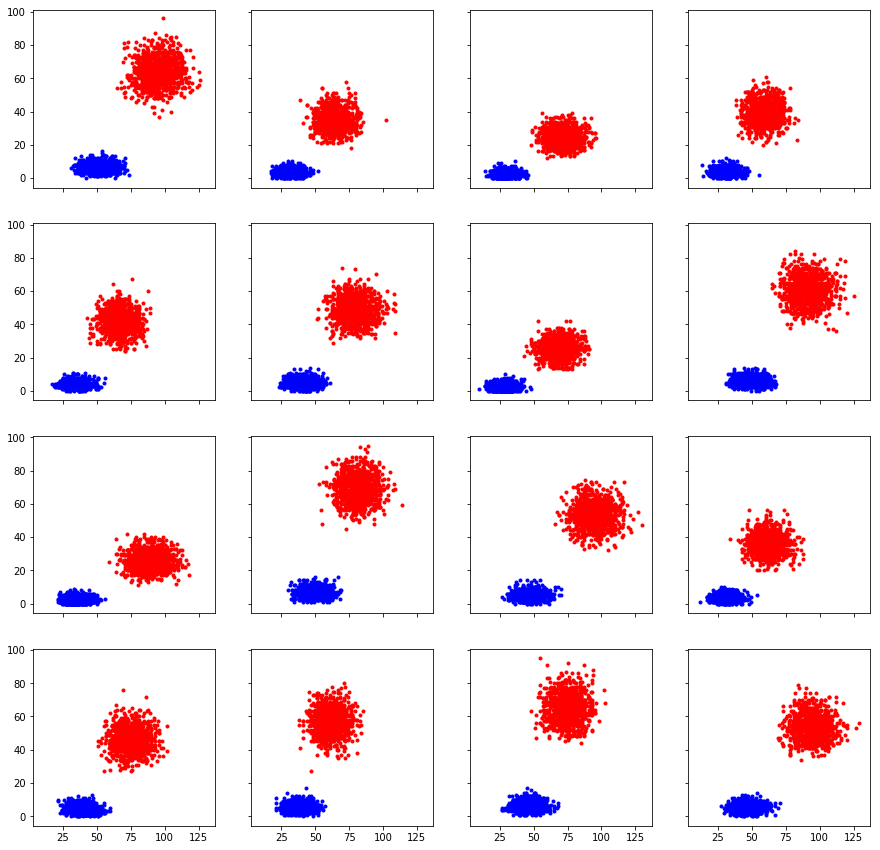

In [6]:
fig, axs = plt.subplots(nrows=4, ncols=4, figsize=(15, 15), sharex=True, sharey=True, facecolor='w', edgecolor='k')
fig.subplots_adjust(hspace = 0.2, wspace=0.2)

axs = axs.ravel()

for plot_ in range(16):
    
    plot_num = np.random.randint(0,len(oneNtruth_set))
            
    axs[plot_].scatter(oneNtruth_set[plot_num],twoNtruth_set[plot_num],c='r',marker='.',alpha=1)
    axs[plot_].scatter(oneNobs_set[plot_num],twoNobs_set[plot_num],c='b',marker='.',alpha=1)
    

In [7]:
# scale everything down to NN size
xscale = NN_x_max/x_max
yscale = NN_y_max/y_max

oneNtruth_set_ = [np.array(i)*xscale for i in oneNtruth_set]
twoNtruth_set_ = [np.array(i)*yscale for i in twoNtruth_set]
oneNobs_set_   = [np.array(i)*xscale for i in oneNobs_set]
twoNobs_set_   = [np.array(i)*yscale for i in twoNobs_set]

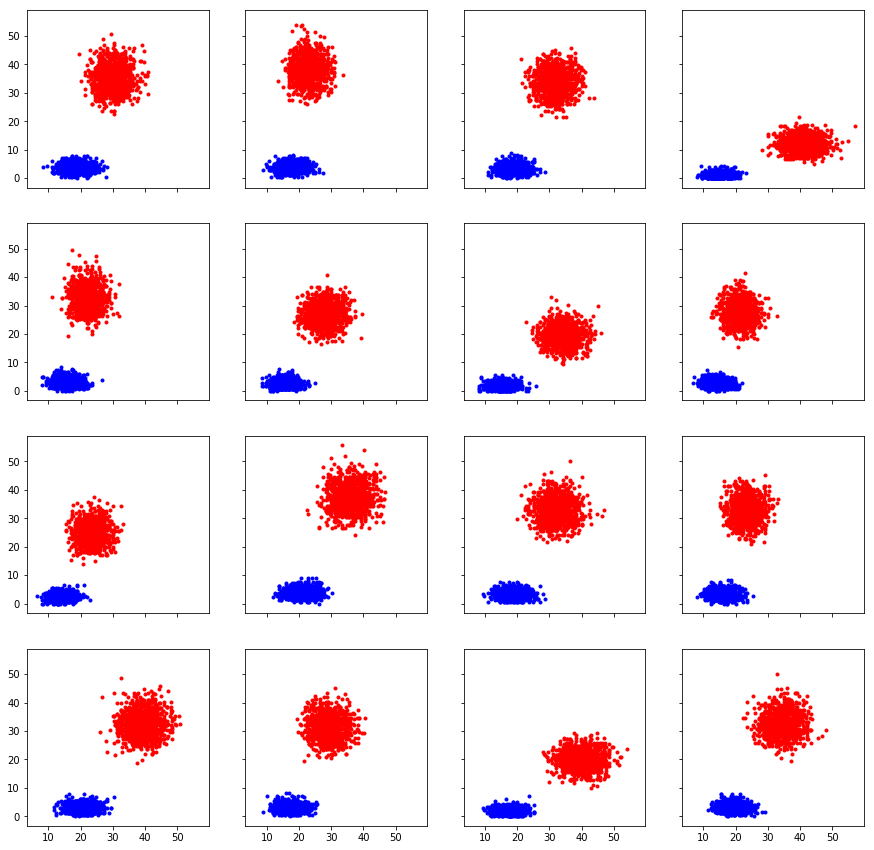

In [8]:
fig, axs = plt.subplots(nrows=4, ncols=4, figsize=(15, 15), sharex=True, sharey=True, facecolor='w', edgecolor='k')
fig.subplots_adjust(hspace = 0.2, wspace=0.2)

axs = axs.ravel()

for plot_ in range(16):
    
    plot_num = np.random.randint(0,len(oneNtruth_set))
            
    axs[plot_].scatter(oneNtruth_set_[plot_num],twoNtruth_set_[plot_num],c='r',marker='.',alpha=1)
    axs[plot_].scatter(oneNobs_set_[plot_num],twoNobs_set_[plot_num],c='b',marker='.',alpha=1)
    

In [9]:
truth_set = []
obs_set   = []

# add truths,observations to arrays
for i in range(len(oneNtruth_set_)):
    
    nbins = (NN_x_max + 1)*(NN_y_max + 1)
    truth = np.zeros(nbins)
    obs   = np.zeros(nbins)
    
    oneNtruth = oneNtruth_set_[i]
    twoNtruth = twoNtruth_set_[i]
    oneNobs   = oneNobs_set_[i]
    twoNobs   = twoNobs_set_[i]
    
    for j in range(len(oneNtruth)):
        oneN     = int(oneNtruth[j])
        twoN     = int(twoNtruth[j])
        oneN_obs = int(oneNobs[j])
        twoN_obs = int(twoNobs[j])

        if oneN > 0 or twoN > 0:
            i_truth = oneN + (NN_x_max + 1)*twoN
            truth[i_truth] += 1
        if oneN_obs > 0 or twoN_obs > 0:
            i_obs = oneN_obs + (NN_x_max + 1)*twoN_obs
            obs[i_obs] += 1
        
    # add arrays to set
    truth_set.append(truth)
    obs_set.append(obs)


In [10]:
scaler = StandardScaler()
# Fit the scaler
scaler.fit(obs_set)
# standardize the data
obs_set = scaler.transform(obs_set)

In [11]:
width = (NN_x_max+1)*(NN_y_max+1) # how many nodes in input
epochs = 4
batch_size = 32

model = Sequential()
model.add(Dense(width, input_dim=width, kernel_initializer='normal', activation='relu'))
model.add(Dense(width, kernel_initializer='normal', activation='softmax'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

model.fit(obs_set, np.array(truth_set), epochs=epochs, batch_size=batch_size,verbose=1)

Epoch 1/4
2400/2400 [==============================] - 73s 30ms/step - loss: 1.3343 - acc: 0.9510
Epoch 2/4
2400/2400 [==============================] - 71s 30ms/step - loss: 1.2455 - acc: 0.9510
Epoch 3/4
2400/2400 [==============================] - 72s 30ms/step - loss: 1.2209 - acc: 0.9510
Epoch 4/4
2400/2400 [==============================] - 70s 29ms/step - loss: 1.2028 - acc: 0.9510


In [12]:
unfolded_set = model.predict(obs_set)

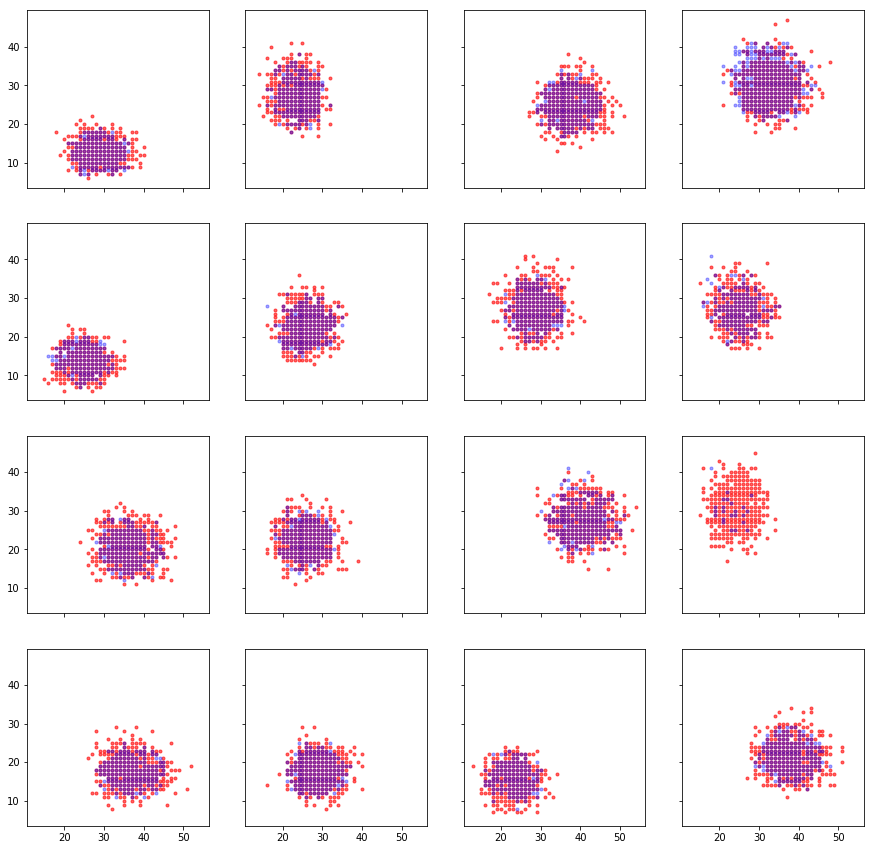

In [13]:
fig, axs = plt.subplots(nrows=4, ncols=4, figsize=(15, 15), sharex=True, sharey=True, facecolor='w', edgecolor='k')
fig.subplots_adjust(hspace = 0.2, wspace=0.2)

axs = axs.ravel()

for plot_ in range(16):
    
    plot_num = np.random.randint(0,len(unfolded_set))
    #plot_num = 5088
    unfolded_plot = unfolded_set[plot_num]
    truth_plot = truth_set[plot_num]
    
    # Selecting the appropriate cut
    unfolded_sort = -np.sort(-unfolded_plot)
    tot_prob = 0
    for i in unfolded_sort:
        tot_prob += i
        if tot_prob >= 0.90:
            cut = i
            break

    # UNFOLDED
    # arrays for scatter plot
    unfolded_x_values = []
    unfolded_y_values = []
    # fill arrays
    for i in range(len(unfolded_plot)):
        if unfolded_plot[i] > cut:
            # calculate x,y values from index
            xval = i % (NN_x_max + 1)
            yval = i // (NN_x_max + 1)
            # add x,y to arrays for scatter plot
            unfolded_x_values.append(xval)
            unfolded_y_values.append(yval)
      
    # TRUTH
    # arrays for scatter plot
    truth_x_values = []
    truth_y_values = []
    # fill arrays
    for i in range(len(truth_plot)):
        if truth_plot[i] > 0:
            # calculate x,y values from index
            xval = i % (NN_x_max + 1)
            yval = i // (NN_x_max + 1)
            # add x,y to arrays for scatter plot
            truth_x_values.append(xval)
            truth_y_values.append(yval)
            
    axs[plot_].scatter(truth_x_values,truth_y_values,c='r',marker='.',alpha=0.6)
    axs[plot_].scatter(unfolded_x_values,unfolded_y_values,c='b',marker='.',alpha=0.35)
    

-------------------------------------------------------------------------------------------------------------------
-------------------------------------------------------------------------------------------------------------------

Now to try a 'real' point

NOTE: THIS DIDNT WORK WELL. Instead at the botton I pulled the correct plots out of the training set.

In [14]:
# empty arrays for truth and observed values
Truth1n = 72
Truth2n = 48

oneNtruth = []
twoNtruth = []
oneNobs   = []
twoNobs   = []

for k in range(nsamples):

    # truth distribution
    oneN = np.random.poisson(Truth1n)
    twoN = np.random.poisson(Truth2n)

    # calculate observed distribution
    oneN_obs = 0
    twoN_obs = 0
    for n in range(oneN):
        rand = np.random.random()
        if rand < M.item(0,0):
            oneN_obs += 1
    for n in range(twoN):
        rand = np.random.random()
        if rand < M.item(0,1):
            oneN_obs += 1
        elif rand < M.item(0,1) + M.item(1,1):
            twoN_obs += 1

    oneNtruth.append(oneN)
    twoNtruth.append(twoN)
    oneNobs.append(oneN_obs)
    twoNobs.append(twoN_obs)
print(oneNobs[0],twoNobs[0])

40 2


(0, 96)

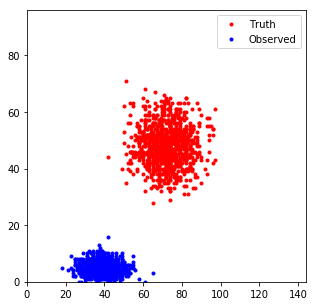

In [15]:
# make the plot
fig, ax = plt.subplots( nrows=1, ncols=1, figsize=(5, 5) )  # create figure & 1 axis
            
ax.scatter(oneNtruth,twoNtruth,c='r',marker='.',label='Truth')
ax.scatter(oneNobs,twoNobs,c='b',marker='.',label='Observed')
ax.legend()
ax.set_xlim([0,2*Truth1n])
ax.set_ylim([0,2*Truth2n])

In [16]:
# scale down
oneNtruth = [int(xscale*i) for i in oneNtruth]
twoNtruth = [int(yscale*i) for i in twoNtruth]
oneNobs   = [int(xscale*i) for i in oneNobs]
twoNobs   = [int(yscale*i) for i in twoNobs]

(0, 70)

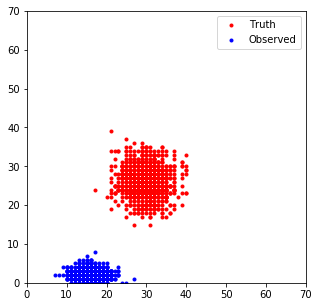

In [17]:
# make the plot
fig, ax = plt.subplots( nrows=1, ncols=1, figsize=(5, 5) )  # create figure & 1 axis
            
ax.scatter(oneNtruth,twoNtruth,c='r',marker='.',label='Truth')
ax.scatter(oneNobs,twoNobs,c='b',marker='.',label='Observed')
ax.legend()
ax.set_xlim([0,NN_x_max])
ax.set_ylim([0,NN_y_max])

In [18]:
# empty arrays for truth and observed values
nbins = (NN_x_max + 1)*(NN_y_max + 1)
truth_small = np.zeros(nbins)
obs_small = np.zeros(nbins)

for k in range(len(oneNtruth)):
    oneN = oneNtruth[k]
    twoN = twoNtruth[k]
    oneN_obs = oneNobs[k]
    twoN_obs = twoNobs[k]
    
    # add truth,observation to arrays
    i_truth = oneN + (NN_x_max + 1)*twoN
    truth_small[i_truth] += 1
    i_obs = oneN_obs + (NN_x_max + 1)*twoN_obs
    obs_small[i_obs] += 1

In [19]:
obs_set = np.array([obs_small for i in range(batch_size)])

In [20]:
# standardize the data
obs_set = scaler.transform(obs_set)

In [21]:
unfolded_small = model.predict(obs_set)

(0, 96)

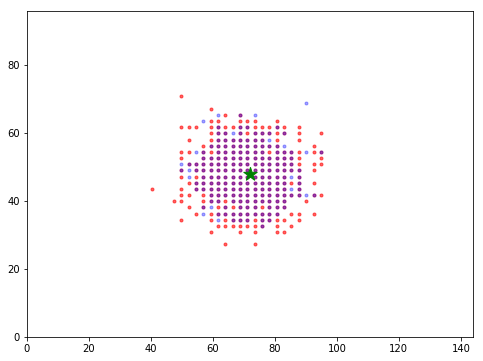

In [22]:
fig, ax = plt.subplots(1,1,figsize=(8,6))

plot_num = 0
unfolded_plot = unfolded_small[plot_num]
truth_plot = truth_small

# Selecting the appropriate cut
unfolded_sort = -np.sort(-unfolded_plot)
tot_prob = 0
for i in unfolded_sort:
    tot_prob += i
    if tot_prob >= 0.90:
        cut = i
        break

# UNFOLDED
# arrays for scatter plot
unfolded_x_values = []
unfolded_y_values = []
# fill arrays
for i in range(len(unfolded_plot)):
    if unfolded_plot[i] > cut:
        # calculate x,y values from index
        xval = i % (NN_x_max + 1)
        yval = i // (NN_x_max + 1)
        # add x,y to arrays for scatter plot
        unfolded_x_values.append(xval/xscale)
        unfolded_y_values.append(yval/yscale)

# TRUTH
# arrays for scatter plot
truth_x_values = []
truth_y_values = []
# fill arrays
for i in range(len(truth_plot)):
    if truth_plot[i] > 0:
        # calculate x,y values from index
        xval = i % (NN_x_max + 1)
        yval = i // (NN_x_max + 1)
        # add x,y to arrays for scatter plot
        truth_x_values.append(xval/xscale)
        truth_y_values.append(yval/yscale)
        

ax.scatter(truth_x_values,truth_y_values,c='r',marker='.',alpha=0.6)
ax.scatter(unfolded_x_values,unfolded_y_values,c='b',marker='.',alpha=0.35)
ax.scatter(Truth1n,Truth2n,c='green',marker='*',s=200)
ax.set_xlim(0,2*Truth1n)
ax.set_ylim(0,2*Truth2n)

----------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------

Now I am going to try a single observation with the pseudo poisson distribution around the observation

In [107]:
#Good (35,8)

Obs1n = 35
Obs2n = 8

oneNobs = []
twoNobs = []

for k in range(nsamples):

    # truth distribution
    oneN_obs = np.random.poisson(Obs1n)
    twoN_obs = np.random.poisson(Obs2n)
    
    oneNobs.append(oneN_obs)
    twoNobs.append(twoN_obs)

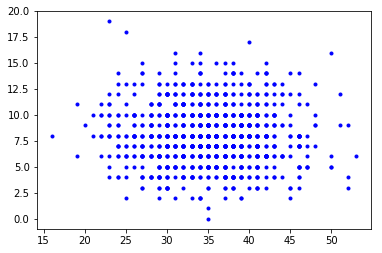

In [108]:
plt.scatter(oneNobs,twoNobs,c='b',marker='.')

In [109]:
oneNobs = [int(i*xscale) for i in oneNobs]
twoNobs = [int(i*yscale) for i in twoNobs]

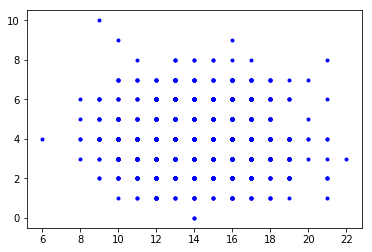

In [110]:
plt.scatter(oneNobs,twoNobs,c='b',marker='.')

In [111]:
# empty arrays for truth and observed values
nbins = (NN_x_max + 1)*(NN_y_max + 1)
obs_small = np.zeros(nbins)

for k in range(len(oneNobs)):
    oneN_obs = oneNobs[k]
    twoN_obs = twoNobs[k]
    
    # add truth,observation to arrays
    i_obs = oneN_obs + (NN_x_max + 1)*twoN_obs
    obs_small[i_obs] += 1

In [112]:
obs_set = np.array([obs_small for i in range(batch_size)])

In [113]:
# standardize the data
obs_set = scaler.transform(obs_set)

In [114]:
unfolded_small = model.predict(obs_set)

(0, 96)

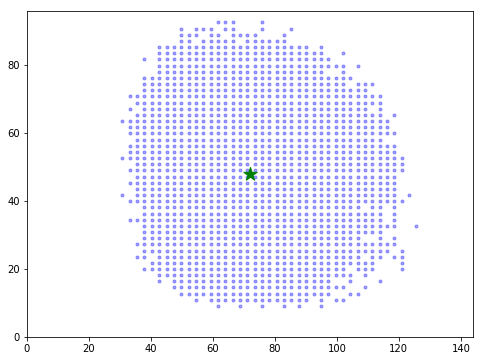

In [124]:
fig, ax = plt.subplots(1,1,figsize=(8,6))

plot_num = 0
unfolded_plot = unfolded_small[plot_num]

# Selecting the appropriate cut
unfolded_sort = -np.sort(-unfolded_plot)
tot_prob = 0
for i in unfolded_sort:
    tot_prob += i
    if tot_prob >= 0.90:
        cut = i
        break

# UNFOLDED
# arrays for scatter plot
unfolded_x_values = []
unfolded_y_values = []
# fill arrays
for i in range(len(unfolded_plot)):
    if unfolded_plot[i] > 0:#cut:
        # calculate x,y values from index
        xval = i % (NN_x_max + 1)
        yval = i // (NN_x_max + 1)
        # add x,y to arrays for scatter plot
        unfolded_x_values.append(xval/xscale)
        unfolded_y_values.append(yval/yscale)
        

ax.scatter(unfolded_x_values,unfolded_y_values,c='b',marker='.',alpha=0.35)
ax.scatter(Truth1n,Truth2n,c='green',marker='*',s=200)
ax.set_xlim(0,2*Truth1n)
ax.set_ylim(0,2*Truth2n)